In [1]:
import matplotlib._color_data as mcd
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np
import pandas as pd
import os
os.chdir("C:\\Users\\Zber\\Documents\\Dev_program\\OpenRadar")

from sklearn.metrics import roc_curve, auc, det_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from scipy.special import softmax
import matplotlib.ticker as ticker

In [2]:
n_classes = 7
classes = [i for i in range(7)]
lw = 3
res_path = "C:/Users/Zber/Documents/Dev_program/OpenRadar/FER/results"
ours_path = os.path.join(res_path,"Evaluate_ours_20220622-125913")
unsuper_path = os.path.join(res_path,"Evaluate_unsupervised_20220622-125515")
landmark_path = os.path.join(res_path,"evaluate_Supervision_heatmap_landmark_baseline_20220622-124706")
kd_path = os.path.join(res_path,"evaluate_KD_20220629-172326")

In [3]:
from sklearn.metrics import classification_report
emotion_list = ['Neutral', 'Happiness', 'Surprise', 'Anger', 'Sadness', 'Fear', 'Disgust']

all = [ours_path, unsuper_path, landmark_path, kd_path]
y_score = []
y_test = []
f_micro = []
t_micro = []
roc_auc = []
accs = []
ii = 0
for path in all:

    csv_path = os.path.join(path,'metrics.csv')
    output_path = os.path.join(path, 'outputs.npy')
    y_score = softmax(np.load(output_path), axis=1)

    i = 0
    for ys in y_score:
        y_score[i] = ys/np.sum(ys)
        i+=1

    df = pd.read_csv (csv_path, sep='\t')
    pred = np.asarray(df['predict'],dtype=int)
    y_targett = np.asarray(df['target'],dtype=int)
    y_target= label_binarize(y_targett, classes=classes)
    print(classification_report(y_targett, pred, target_names=emotion_list, digits=4))
    fpr, tpr, _ = roc_curve(y_target.ravel(), y_score.ravel())
    f_micro.append(fpr)
    t_micro.append(tpr)
    roc_auc.append(auc(fpr, tpr))
    ii+=1
    

              precision    recall  f1-score   support

     Neutral     0.9189    0.9714    0.9444        35
   Happiness     0.7447    1.0000    0.8537        35
    Surprise     0.9333    0.9032    0.9180        31
       Anger     0.8387    0.7647    0.8000        34
     Sadness     0.8710    0.7500    0.8060        36
        Fear     0.8750    0.8000    0.8358        35
     Disgust     0.9118    0.8611    0.8857        36

    accuracy                         0.8636       242
   macro avg     0.8705    0.8644    0.8634       242
weighted avg     0.8697    0.8636    0.8626       242

              precision    recall  f1-score   support

     Neutral     0.9722    1.0000    0.9859        35
   Happiness     0.6957    0.9143    0.7901        35
    Surprise     0.8621    0.8065    0.8333        31
       Anger     0.7222    0.7647    0.7429        34
     Sadness     0.8966    0.7222    0.8000        36
        Fear     0.6207    0.5143    0.5625        35
     Disgust     0.6757 

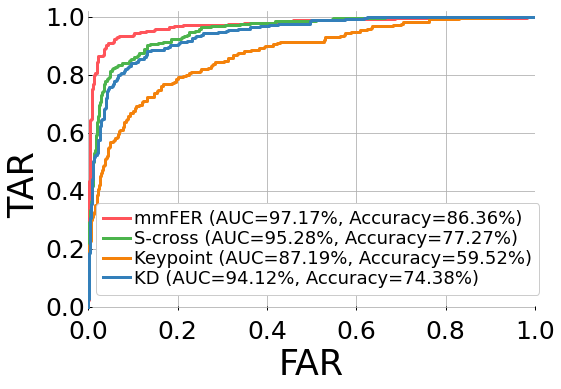

In [5]:
fig, ax = plt.subplots(figsize=(8, 5.5))
colors = ["#FF545A", "#4CB44C", "#F4820B",  "#337FBA", "#C775FF"]
label = ['mmFER', 'S-cross', 'Keypoint', 'KD']

acs  =[86.36, 77.27, 59.52, 74.38]

lw = 3

i = 0

for fpr, tpr, roc, c in zip(f_micro, t_micro, roc_auc, colors):
    if label[i] == 'Ours':
        zr = 10
    else:
        zr = 5
    ax.plot(fpr, tpr, c=c, linewidth=lw,
            label="{} (AUC={:.2f}%, Accuracy={:.2f}%)".format(label[i], roc*100, acs[i]), zorder=zr)
    i = i+1

# ax.plot([0, 1], [0, 1], "k--", lw=lw)

ax.grid()
# ax.set_ylabel("True positive rate", fontsize=35)
ax.set_ylabel("TAR", fontsize=35, y=0.42)
# ax.set_xlabel("False positive rate", fontsize=35)
ax.set_xlabel("FAR", fontsize=35)
ax.yaxis.set_tick_params(labelsize=25, length=4, direction='in', width=1)
ax.xaxis.set_tick_params(labelsize=25, length=4, direction='in', width=1, pad=10)
ax.set_xlim(0.0, 1.0)
ax.set_ylim(-0.01, 1.02)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))

ax.legend(loc="lower right", prop={'size': 18, }, ncol=1, fancybox=True, bbox_to_anchor=(1.03, 0.02),
          labelspacing=0.1, framealpha=1.0, handletextpad=0.2, columnspacing=0.5, handlelength=1.5)
fig.savefig('C:/Users/Zber/Desktop/mmEmo_Exp/0.Method/Fig16_ROC.svg', format='svg', bbox_inches="tight")


In [21]:
def roc(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # y_score = np.log2(y_score)

    for i in range(n_classes):
        fpr[i], tpr[i], threshold = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc, threshold

In [46]:
path = ours_path
csv_path = os.path.join(path,'metrics.csv')
output_path = os.path.join(path, 'outputs.npy')
y_score = softmax(np.load(output_path), axis=1)

y_max = np.argmax(y_score, axis=1)

# y_score = np.zeros((len(y_score), n_classes))

# for i, m in enumerate(y_max):
#     y_score[i, m] =  1

# y_score = np.load(output_path)
df = pd.read_csv (csv_path, sep='\t')
y_target = np.asarray(df['target'],dtype=int)
y_target= label_binarize(y_target, classes=classes)
y_test = y_target
fpr, tpr, roc_auc, threshold = roc(y_test, y_score)

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
# roc_auc["micro"] = roc_auc_score(fpr["micro"], tpr["micro"])
roc_auc["micro"] = roc_auc_score(y_test, y_score)

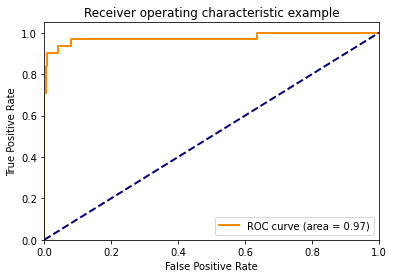

In [48]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

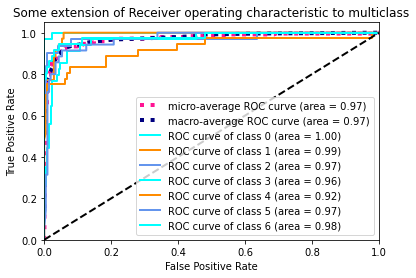

In [49]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()